In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
%run ../Segmentation/Segmenter.ipynb

In [8]:
class sheet_generator:
    def __init__(self, note_model, string_model, segmentation_model=Segmenter()):
        self.note_model = load_NN(note_model, verbose=0)
        self.string_model = load_NN(string_model, verbose=0)
        self.segmentation_model = segmentation_model
    
    def create_sheet(self, wave, show_plots):
        onsets = list(map(int, self.segmentation_model.predict(wave, show_plots)))
        
        # For now we add the end of file as an extra onset
        onsets.append(len(wave.y))
        results = []
        
        for i in tqdm(range(len(onsets) - 1), leave=False):
            note = waveform(wave.y[onsets[i]:onsets[i+1]])
            
            if len(note.y) >= 500:
                note_pred = librosa.midi_to_note(np.argmax(self.note_model.predict(note.temp_data(500))) + 28)

                # Run the string prediction over chunks of the entire note to get a more accurate prediction
                string_predictions = np.array(note.apply_window(500, 100, self.string_model.predict, True, False, True))[:,1]
                string_pred = int(np.median(np.array([np.argmax(x) for x in string_predictions])) + 1)
                results.append([note_pred, string_pred])
        
        return results

In [9]:
SG = sheet_generator("../Single_note_models/Guitar/Guitar", "../Single_note_models/Guitar/Guitar_norm_string")

[['G#3', 4],
 ['A3', 4],
 ['G#3', 4],
 ['A3', 4],
 ['G#3', 4],
 ['A#3', 4],
 ['G#3', 4],
 ['A#3', 4],
 ['G#3', 4],
 ['G#4', 2],
 ['G#3', 4],
 ['F#4', 2]]

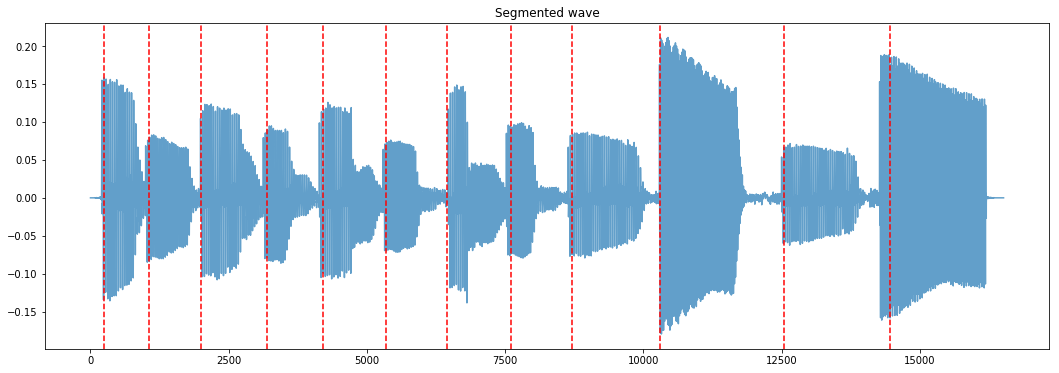

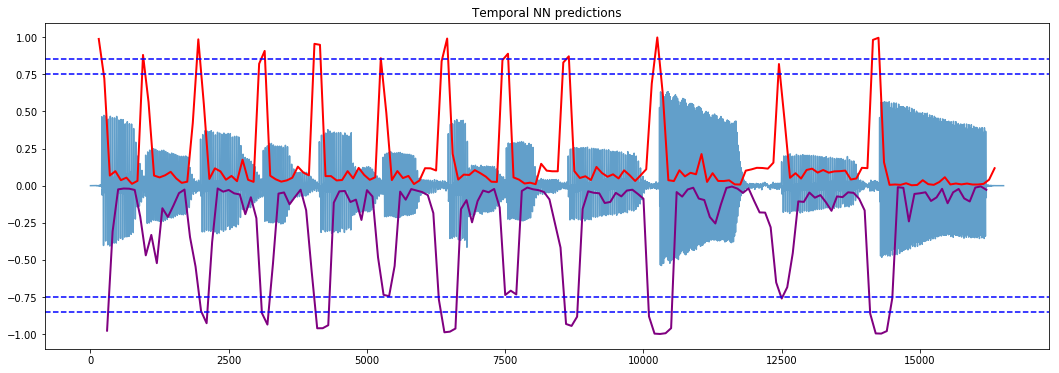

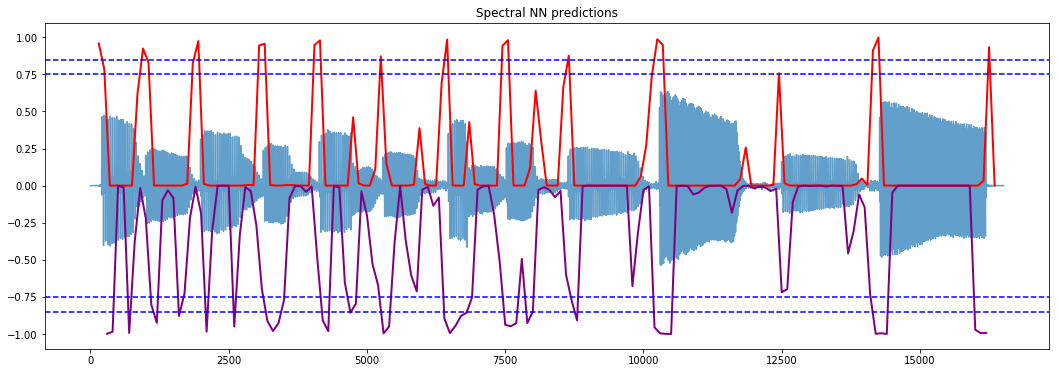

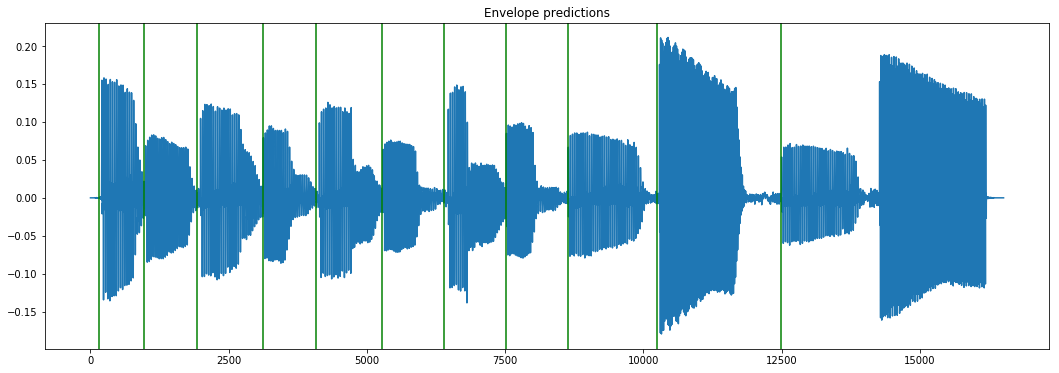

In [11]:
SG.create_sheet(waveform("../Samples/Guitar/Riffs/Guitar_noamp_riff15.mp3"), True)

In [7]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3", 8000)

In [8]:
nn = load_NN("../Single_note_models/Guitar/Guitar_norm_string")

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               128256    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
Total params: 162,184
Trainable params: 162,184
Non-trainable params: 0
_________________________________________________________________


In [11]:
wave = waveform(y[2000:3000])

In [12]:
wave.apply_window(size=500, disp=100, function=nn.predict, convert=True, temp=False, norm=True)

[[0, array([[7.4579865e-12, 5.4021672e-09, 1.5861205e-04, 1.1174503e-02,
          5.5825058e-03, 9.8308438e-01, 1.8192850e-10, 4.2824269e-08]],
        dtype=float32)],
 [100, array([[1.2866234e-22, 3.5799723e-16, 9.8138841e-10, 4.1529521e-08,
          2.1631409e-05, 9.9986577e-01, 6.0027383e-09, 1.1268476e-04]],
        dtype=float32)],
 [200, array([[5.8004474e-28, 3.6872836e-21, 3.1265906e-12, 3.6657983e-09,
          5.4578614e-08, 9.9999952e-01, 1.7889034e-09, 4.2223277e-07]],
        dtype=float32)],
 [300, array([[1.3240358e-30, 6.4164376e-22, 2.6150490e-13, 3.8050356e-08,
          4.5794892e-09, 9.9999905e-01, 2.6372351e-08, 9.3315356e-07]],
        dtype=float32)],
 [400, array([[3.9646509e-31, 3.9855492e-22, 1.2482922e-12, 2.0387901e-07,
          5.5006559e-09, 9.9999595e-01, 3.5880416e-06, 2.4721504e-07]],
        dtype=float32)]]